In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-14 15:05:13.183761: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-14 15:05:15.666880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 15:05:15.669050: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-14 15:05:16.069841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 15:05:16.072334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key_fulldata(y_train)

In [10]:
last_key

10883

In [11]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13449, 512, 512, 1) (13449, 512, 512, 1) (3317, 512, 512, 1) (3317, 512, 512, 1)


In [12]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13449, 512, 512, 1) (3317, 512, 512, 1)


In [13]:
#X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

In [14]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('float64'), dtype('bool'), dtype('float64'), dtype('float64'))

In [15]:
m_train.dtype

dtype('bool')

In [16]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [17]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [18]:
train_images_array = train_images_array.astype(np.float32)

In [19]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

In [20]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [21]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [22]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[10], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[10])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[10])
# axes[2].set_title('Processed Image')
# plt.show()

In [23]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [24]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [25]:
test_images_array = test_images_array.astype(np.float32)

In [26]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [27]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [28]:
#y_train_set = y_train_set.astype(np.float32)

In [29]:
#y_val = y_val.astype(np.float32)

In [30]:
X_train_set.dtype, y_train_set.dtype

(dtype('float32'), dtype('bool'))

In [31]:
X_val.dtype, y_val.dtype

(dtype('float32'), dtype('bool'))

In [32]:
test_images_array.dtype, y_test.dtype

(dtype('float32'), dtype('float64'))

In [33]:
X_val.shape, y_val.shape

((2566, 512, 512, 1), (2566, 512, 512, 1))

In [34]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-14 15:08:37.835693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 15:08:37.838231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 15:08:37.848854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-14 15:08:37.852008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 15:08:37.854463: I tensorflow/core

In [35]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-14 15:08:42.475455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-14 15:08:42.494768: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-14 15:08:44.123161: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-14 15:08:44.928361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-14 15:08:45.920940: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-14 15:08:45.920966: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-14 15:08:45.921320: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-14 15:08:46.002251: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-14 15:08:46.993515: I tensorflow/stream_exec

680/680 [==============================] - 331s 467ms/step - loss: 0.0839 - iou: 4.2892e-05 - iou_thresholded: 0.3147 - val_loss: 0.0029 - val_iou: 9.7012e-05 - val_iou_thresholded: 0.9026
Epoch 2/200
680/680 [==============================] - 306s 445ms/step - loss: 0.0015 - iou: 3.1957e-04 - iou_thresholded: 0.4191 - val_loss: 7.2510e-04 - val_iou: 5.4095e-04 - val_iou_thresholded: 0.8587
Epoch 3/200
680/680 [==============================] - 302s 445ms/step - loss: 5.1056e-04 - iou: 0.0011 - iou_thresholded: 0.4091 - val_loss: 3.6585e-04 - val_iou: 8.1792e-04 - val_iou_thresholded: 0.9026
Epoch 4/200
680/680 [==============================] - 302s 445ms/step - loss: 2.6105e-04 - iou: 0.0027 - iou_thresholded: 0.3906 - val_loss: 1.8938e-04 - val_iou: 0.0037 - val_iou_thresholded: 0.8337
Epoch 5/200
680/680 [==============================] - 302s 445ms/step - loss: 1.7461e-04 - iou: 0.0049 - iou_thresholded: 0.3724 - val_loss: 1.3753e-04 - val_iou: 0.0027 - val_iou_thresholded: 0.9026

Epoch 42/200
680/680 [==============================] - 302s 445ms/step - loss: 1.0366e-05 - iou: 0.4298 - iou_thresholded: 0.7442 - val_loss: 2.8251e-05 - val_iou: 0.5540 - val_iou_thresholded: 0.8807
Epoch 43/200
680/680 [==============================] - 302s 444ms/step - loss: 1.0269e-05 - iou: 0.4625 - iou_thresholded: 0.7512 - val_loss: 3.1956e-05 - val_iou: 0.6056 - val_iou_thresholded: 0.8605
Epoch 44/200
680/680 [==============================] - 302s 445ms/step - loss: 1.0024e-05 - iou: 0.4648 - iou_thresholded: 0.7522 - val_loss: 2.3374e-05 - val_iou: 0.3289 - val_iou_thresholded: 0.8807
Epoch 45/200
680/680 [==============================] - 302s 445ms/step - loss: 1.1067e-05 - iou: 0.4437 - iou_thresholded: 0.7362 - val_loss: 2.3888e-05 - val_iou: 0.5294 - val_iou_thresholded: 0.8894
Epoch 46/200
680/680 [==============================] - 302s 445ms/step - loss: 9.9975e-06 - iou: 0.4708 - iou_thresholded: 0.7517 - val_loss: 3.1969e-05 - val_iou: 0.6587 - val_iou_thresholde

680/680 [==============================] - 302s 445ms/step - loss: 5.5861e-06 - iou: 0.6864 - iou_thresholded: 0.8474 - val_loss: 4.0860e-05 - val_iou: 0.6711 - val_iou_thresholded: 0.8400
Epoch 83/200
680/680 [==============================] - 302s 445ms/step - loss: 5.5953e-06 - iou: 0.6984 - iou_thresholded: 0.8483 - val_loss: 3.7087e-05 - val_iou: 0.7574 - val_iou_thresholded: 0.8696
Epoch 84/200
680/680 [==============================] - 302s 444ms/step - loss: 5.5743e-06 - iou: 0.6847 - iou_thresholded: 0.8482 - val_loss: 4.7666e-05 - val_iou: 0.7309 - val_iou_thresholded: 0.8628
Epoch 85/200
680/680 [==============================] - 302s 445ms/step - loss: 5.5066e-06 - iou: 0.7088 - iou_thresholded: 0.8477 - val_loss: 3.8908e-05 - val_iou: 0.7898 - val_iou_thresholded: 0.8778
Epoch 86/200
680/680 [==============================] - 302s 445ms/step - loss: 6.1700e-06 - iou: 0.6913 - iou_thresholded: 0.8409 - val_loss: 3.0906e-05 - val_iou: 0.7219 - val_iou_thresholded: 0.8691
Epo

680/680 [==============================] - 302s 445ms/step - loss: 3.3316e-06 - iou: 0.8326 - iou_thresholded: 0.8989 - val_loss: 5.5610e-05 - val_iou: 0.8485 - val_iou_thresholded: 0.8866
Epoch 123/200
680/680 [==============================] - 303s 446ms/step - loss: 3.6672e-06 - iou: 0.8279 - iou_thresholded: 0.8939 - val_loss: 5.9574e-05 - val_iou: 0.8183 - val_iou_thresholded: 0.8741
Epoch 124/200
680/680 [==============================] - 302s 444ms/step - loss: 3.6129e-06 - iou: 0.8273 - iou_thresholded: 0.8975 - val_loss: 5.0968e-05 - val_iou: 0.8138 - val_iou_thresholded: 0.8805
Epoch 125/200
680/680 [==============================] - 302s 444ms/step - loss: 3.5302e-06 - iou: 0.8329 - iou_thresholded: 0.8957 - val_loss: 5.6826e-05 - val_iou: 0.8124 - val_iou_thresholded: 0.8771
Epoch 126/200
680/680 [==============================] - 302s 445ms/step - loss: 3.5661e-06 - iou: 0.8313 - iou_thresholded: 0.9044 - val_loss: 5.9682e-05 - val_iou: 0.8002 - val_iou_thresholded: 0.8799

680/680 [==============================] - 302s 445ms/step - loss: 2.3477e-06 - iou: 0.8811 - iou_thresholded: 0.9324 - val_loss: 7.5041e-05 - val_iou: 0.8286 - val_iou_thresholded: 0.8561
Epoch 163/200
680/680 [==============================] - 302s 445ms/step - loss: 2.2337e-06 - iou: 0.8893 - iou_thresholded: 0.9394 - val_loss: 7.8190e-05 - val_iou: 0.8335 - val_iou_thresholded: 0.8536
Epoch 164/200
680/680 [==============================] - 302s 445ms/step - loss: 2.0704e-06 - iou: 0.8979 - iou_thresholded: 0.9370 - val_loss: 7.5160e-05 - val_iou: 0.7944 - val_iou_thresholded: 0.8421
Epoch 165/200
680/680 [==============================] - 302s 445ms/step - loss: 1.9470e-06 - iou: 0.9013 - iou_thresholded: 0.9428 - val_loss: 7.2397e-05 - val_iou: 0.8527 - val_iou_thresholded: 0.8735
Epoch 166/200
680/680 [==============================] - 302s 445ms/step - loss: 1.8082e-06 - iou: 0.9049 - iou_thresholded: 0.9418 - val_loss: 7.4411e-05 - val_iou: 0.8006 - val_iou_thresholded: 0.8269

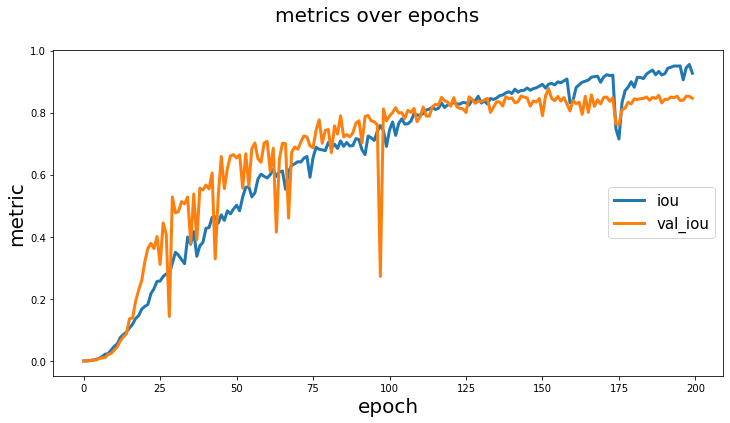

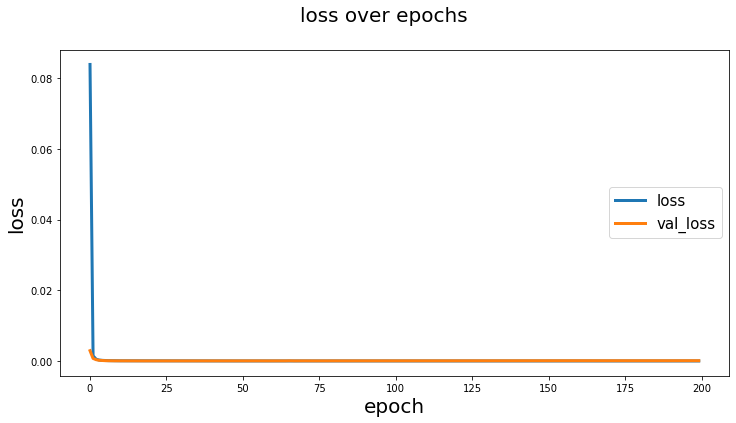

In [36]:
C.Helper.visualize_graph(history)

In [ ]:
y_pred = C.Helper.prediction(test_images_array, model)

In [ ]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [ ]:
C.Helper.evaluate(test_images_array, y_test, model)